In [ ]:
#!unzip "/content/drive/MyDrive/Classical-Piano-Composer-master.zip" -d "/content/drive/MyDrive/music_project/" 

In [ ]:
%cd /content/drive/MyDrive/music_project/Classical-Piano-Composer-master

/content/drive/MyDrive/music_project/Classical-Piano-Composer-master


**Train the network**

Libraries are imported
Stage-1
Generating the Notes from the music
Parsing <music21.stream.Score 0x7fd1800fb110>
Parsing <music21.stream.Score 0x7fd1801245d0>
Parsing <music21.stream.Score 0x7fd17fe4ced0>
Parsing <music21.stream.Score 0x7fd17f6d65d0>
Parsing <music21.stream.Score 0x7fd17fa66ad0>
Parsing <music21.stream.Score 0x7fd1801048d0>
Parsing <music21.stream.Score 0x7fd17f5b1390>
Parsing <music21.stream.Score 0x7fd17fc34fd0>
Parsing <music21.stream.Score 0x7fd17e898050>
Parsing <music21.stream.Score 0x7fd17e49e950>
Parsing <music21.stream.Score 0x7fd17f601e10>
Parsing <music21.stream.Score 0x7fd17fc94ed0>
Parsing <music21.stream.Score 0x7fd17e337c90>
Parsing <music21.stream.Score 0x7fd17f322e50>
Parsing <music21.stream.Score 0x7fd17f4ef090>
Parsing <music21.stream.Score 0x7fd18002c210>
Parsing <music21.stream.Score 0x7fd17f58d7d0>
Parsing <music21.stream.Score 0x7fd17fa418d0>
Parsing <music21.stream.Score 0x7fd17e93b210>
Parsing <music21.stream.Score 0x7fd17f6209d0>
Parsing <musi

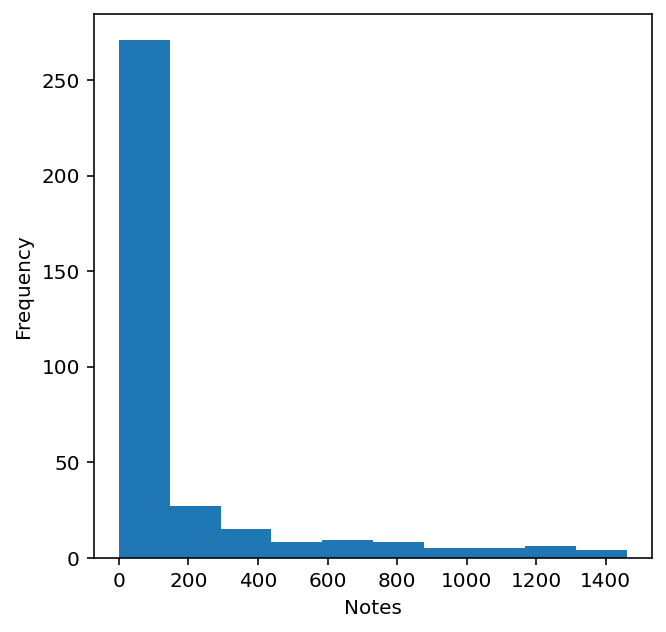

the Notes are generated for the training music
------------------------------------------------------------------------------------
Stage-2
Now we processing the notes to get the input sequence for the LSTM network and corresponding output
Sequence are generated
------------------------------------------------------------------------------------
Stage-3
Creating the network for training the model
The network for training the model is created now and the structure now looks like 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 128)          66560     
_________________________________________________________________
dropout (Dropout)            (None, 100, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 128)          131584    
__________________________________

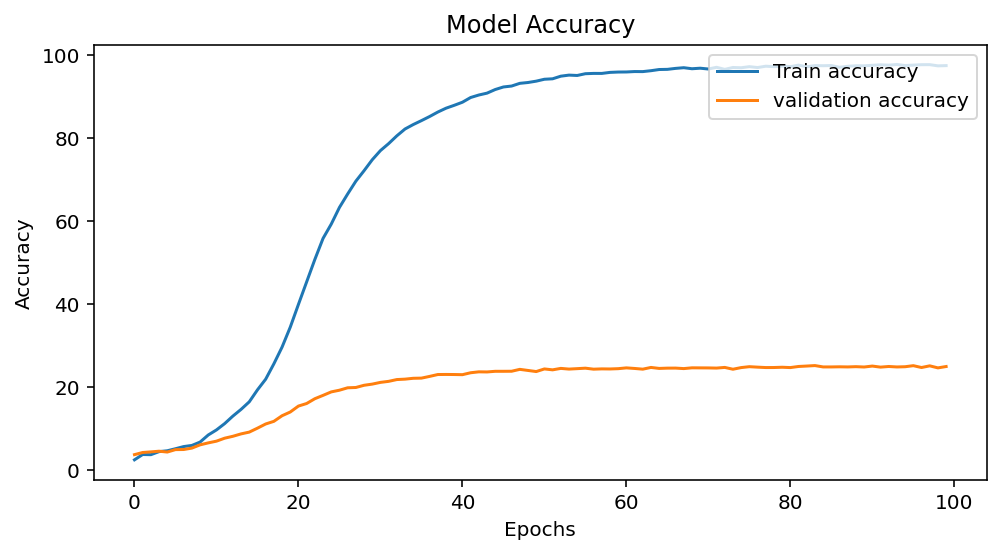

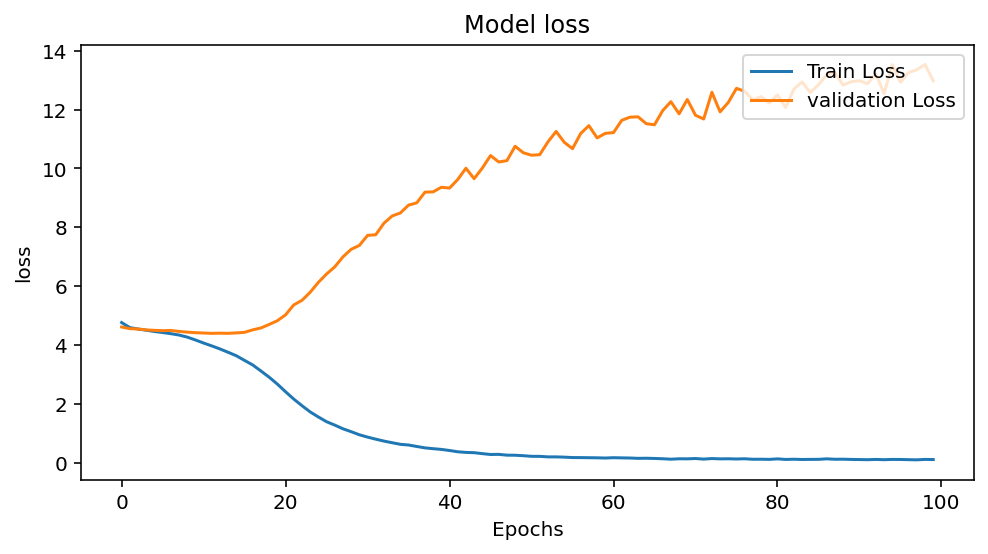

In [ ]:
# midi songs 100 epochs

import numpy
import glob
import pickle
import pickle
from music21 import instrument, note, stream, chord
import numpy
from music21 import converter, instrument, note, chord

from keras.layers import BatchNormalization as BatchNorm
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt

import numpy as np
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense


import tensorflow as tf 
print("Libraries are imported")
%cd /content/drive/MyDrive/music_project/Classical-Piano-Composer-master
def final_music_generation():
    print("Stage-1")
    print("Generating the Notes from the music")
    train_notes = notes_extract()

    from collections import Counter
    freq = dict(Counter(train_notes))
    n = [i for i in freq.values()]

    #plots
    plt.figure(figsize=(5,5))
    plt.hist(n)
    plt.xlabel('Notes')
    plt.ylabel('Frequency')
    plt.show()
    print("the Notes are generated for the training music")
    print("------------------------------------------------------------------------------------")
    print("Stage-2")
    print("Now we processing the notes to get the input sequence for the LSTM network and corresponding output")
    input_sequence, output_coded ,train_pitch= input_output_sequences(train_notes)
    train_input_sequence, x_val, train_output_coded, y_val = train_test_split(input_sequence, output_coded,test_size=0.6,random_state=0)
    print("Sequence are generated")
    print("------------------------------------------------------------------------------------")
    print("Stage-3")
    print("Creating the network for training the model")
    # pitches length 
    length_notes=len(train_pitch)

    model=model_create(train_input_sequence, length_notes) 
    print("The network for training the model is created now and the structure now looks like ")
    model.summary()
    #model.tf_model.load_weights('best_model_main.hdf5')
    print('Model Loaded')
    print("------------------------------------------------------------------------------------")
    print("train the network")
    epochs=100
    results=train(model,train_input_sequence, train_output_coded,train_pitch,epochs,x_val,y_val)
    print("The model has been trained and the weights are saved to the files")
    print("Now, run the predict.py file to make a new music")

    return results


def notes_extract():
    """ Get all the notes and chords from the midi files in the ./midi_songs directory """
    """
    Function- notes_extract

    Input - None
    Function- We are getting the notes and the chords that are preprocessed from the music files mainly the midi files.
    output- Notes file that will be saved in a folder and also the informations that are collected from the notes and the chords 

    """
    main = []

    for info in glob.glob("midi_songs_new/*.mid"): # looking at the each files to get the all the list of notes and the chords that are present in the songs
        list_midi = converter.parse(info)

        print("Parsing %s" % list_midi)

        notes_parts = None
        
        # file has instrument parts along with the piano and some flat structure
        try: 
            s2 = instrument.partitionByInstrument(list_midi)
            notes_parts = s2.parts[0].recurse() 
            #print(s2)
            #print(notes_parts)
        except:

            # to extract the flat structures in the music
            notes_parts = list_midi.flat.notes
            #print(notes_parts)

        # after we separte the data from the music stream with the help of the music21, we can extract the notes and the chords from the music files.
        # As, we said, the data can be slplited into 2 types such as notes and the Chords.
        for objects in notes_parts: 
            #print(objects)
            # Instance is to check the instance of the class like whether notes or chords
            if isinstance(objects, note.Note): # to check whether it is a notes 
                main.append(str(objects.pitch))
            elif isinstance(objects, chord.Chord):
               # to check whether it is a chord in the music file and appendind it to the file 
                main.append('.'.join(str(n) for n in objects.normalOrder))


    #To save the notes that we have collected from the previous methods.
    with open('data/midi_songs_new100', 'wb') as path: # we are saving it in the data folder and the in the name of notes
        pickle.dump(main, path)

    return main


def input_output_sequences(notes):
   
    #the sequence length is used in the sequence the network which mainly to predict the next notes with the help of the previous 100 notes that would help to make the prediction of music sequence.
    length_seq = 100
    
    # creating a empty sequency for the both input and the output
    input_sequence = []
    output_coded = []

    # we storing the collection of the  multiple notes and chords in the notes variable like
    # we will have many repeated names of notes and chords that are occuring in the music and we are storing that here (ie) pitches in the music

    pitch = sorted(set(item for item in notes))
    n=len(pitch)

    # creating  a dict which will map or join the pitches and its intgers
    #note_to_int = dict((note, number) for number, note in enumerate(pitch))
    a=[]
    b=[]
    for inte, note in enumerate(pitch):
      a.append(inte)
      b.append(note)
    a_dict = {value: key for key, value in zip(a, b)}
      
    #print(a_dict)
    input_lenght=len(notes)-100

    # create input sequences and the corresponding outputs
    input_sequence=[]
    for i in range(0, input_lenght):
        #print(i)
        # for input sequence
        input = notes[i:i + length_seq]
        input_sequence.append([a_dict[char] for char in input])
        #for char in input:
         # input_sequence.append([a_dict[char]])
        # for output sequence
        out = notes[i + length_seq]
        output_coded.append(a_dict[out])


    # reshape the input for the lstm sequence
    input_sequence = numpy.reshape(input_sequence, (len(input_sequence), length_seq, 1))
    # normalize input

    input_sequence = input_sequence / float(n)
    #one-hot encode the output.

    output_coded = np_utils.to_categorical(output_coded)

    return (input_sequence, output_coded,pitch)



def model_create(network_input, n_vocab):
    """ create the structure of the neural network """
    from keras.layers import Activation, Dense, LSTM, Dropout, Flatten
    model = Sequential()
    #layer LSTM one
    model.add(LSTM(128, input_shape=network_input.shape[1:], return_sequences=True))
    # dropout layer
    model.add(Dropout(0.2))
     #layer LSTM 2
    model.add(LSTM(128, return_sequences=True))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Dropout(0.3))
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

def train(LSTM_model,train_input_sequence, train_output_coded,train_pitch,epo,x_val,y_val):
  # pitches length 
  length_notes=len(train_pitch)

  # make LSTM model 
  #LSTM_model=model(train_input_sequence, train_output_coded, length_notes) 
  #LSTM_model.summary()

  files = ModelCheckpoint(
          "weights_midi_songs_new100.hdf5",
          monitor='loss',
          mode='min',
          save_best_only=True,
          verbose=0)

  # train the model
  results=LSTM_model.fit(train_input_sequence, train_output_coded, batch_size=128,epochs=epo,validation_data=(x_val,y_val),callbacks=[files])

  return results


results=final_music_generation()

acc=results.history['accuracy']
acc = [element * 100 for element in acc]
val_acc=results.history['val_accuracy']
val_acc = [element * 100 for element in val_acc]

plt.figure(figsize=(8,4))
plt.plot(acc, label='Train accuracy')
plt.plot(val_acc, label='validation accuracy')

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.show();
#plt.savefig('plot.png')   # or you can pass a Figure object to pdf.savefig
#plt.close()
plt.figure(figsize=(8,4))
plt.plot(results.history['loss'], label='Train Loss')
plt.plot(results.history['val_loss'], label='validation Loss')
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.show();


In [ ]:
#100
!python predict_new.py

2021-10-22 19:39:20.298103: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-22 19:39:20.306521: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-22 19:39:20.307328: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-22 19:39:20.308575: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-22 19:39:20.309362: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Libraries are imported
Stage-1
Generating the Notes from the music
Parsing <music21.stream.Score 0x7f2a36eb56d0>
Parsing <music21.stream.Score 0x7f2a3623acd0>
Parsing <music21.stream.Score 0x7f2a32015c90>
Parsing <music21.stream.Score 0x7f2a24274210>
Parsing <music21.stream.Score 0x7f2a31b58f10>
Parsing <music21.stream.Score 0x7f2a2eed2f10>
Parsing <music21.stream.Score 0x7f2a309b5a90>
Parsing <music21.stream.Score 0x7f2a2257bb10>
Parsing <music21.stream.Score 0x7f2a31e117d0>
Parsing <music21.stream.Score 0x7f2a21622f50>
Parsing <music21.stream.Score 0x7f2a20b73a50>
Parsing <music21.stream.Score 0x7f2a22040990>
Parsing <music21.stream.Score 0x7f2a28a4c4d0>
Parsing <music21.stream.Score 0x7f2a20859950>
Parsing <music21.stream.Score 0x7f2a30c47dd0>
Parsing <music21.stream.Score 0x7f2a32c05210>
Parsing <music21.stream.Score 0x7f2a2eb4a790>
Parsing <music21.stream.Score 0x7f2a30b11ed0>
Parsing <music21.stream.Score 0x7f2a20865390>
Parsing <music21.stream.Score 0x7f2a28c1f910>
Parsing <musi

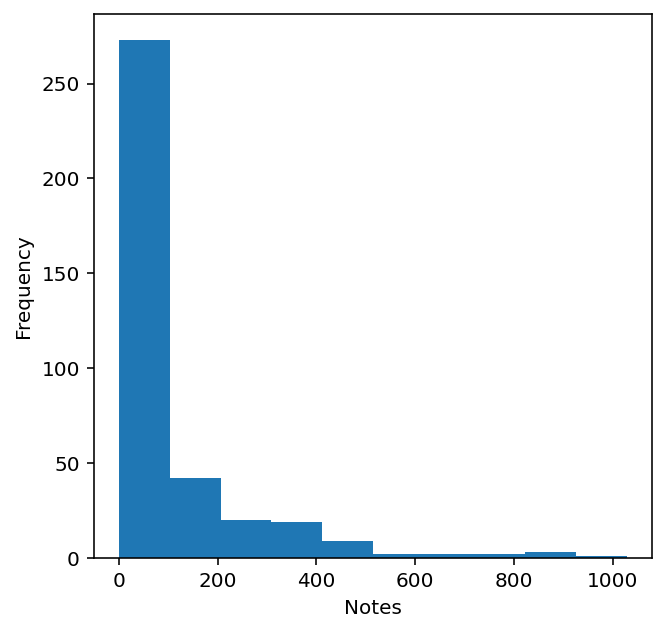

the Notes are generated for the training music
------------------------------------------------------------------------------------
Stage-2
Now we processing the notes to get the input sequence for the LSTM network and corresponding output
Sequence are generated
------------------------------------------------------------------------------------
Stage-3
Creating the network for training the model
The network for training the model is created now and the structure now looks like 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 128)          66560     
_________________________________________________________________
dropout (Dropout)            (None, 100, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 128)          131584    
__________________________________

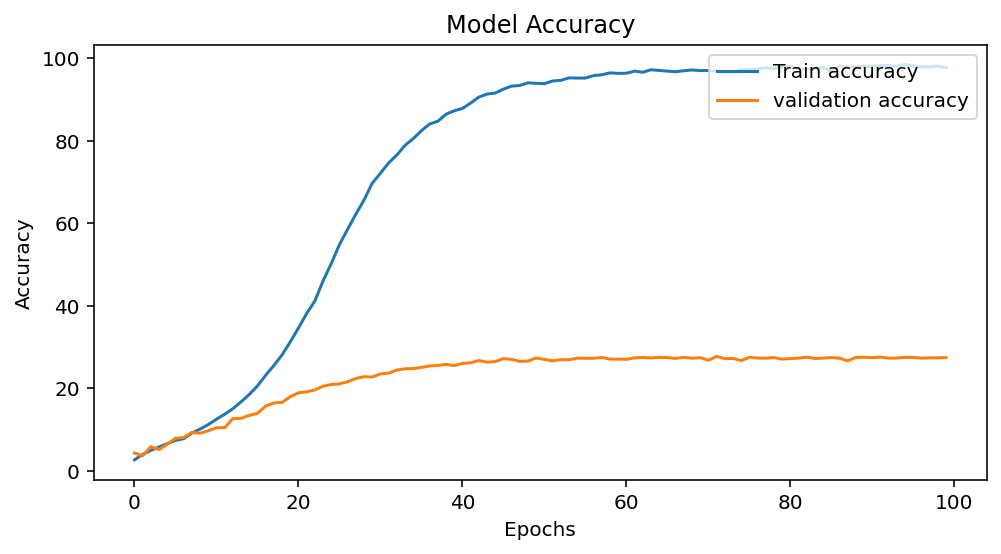

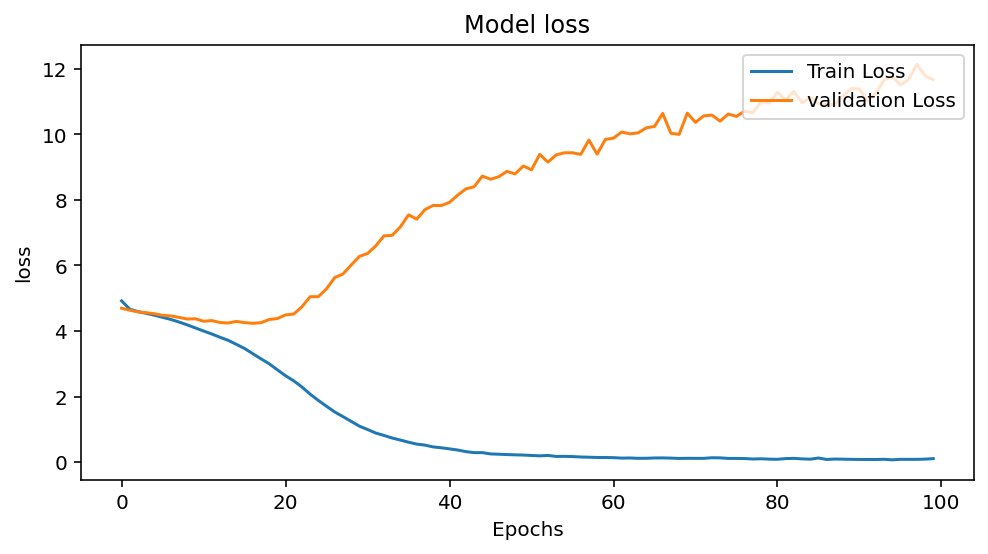

In [ ]:
# not piano 100 epochs
import glob
import pickle
import numpy
from music21 import converter, instrument, note, chord
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import BatchNormalization as BatchNorm
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt

import numpy as np
from sklearn.model_selection import train_test_split


import pickle
import numpy
from music21 import instrument, note, stream, chord

print("Libraries are imported")
%cd /content/drive/MyDrive/music_project/Classical-Piano-Composer-master
def final_music_generation():
    print("Stage-1")
    print("Generating the Notes from the music")
    train_notes = notes_extract()

    from collections import Counter
    freq = dict(Counter(train_notes))
    n = [i for i in freq.values()]

    #plots
    plt.figure(figsize=(5,5))
    plt.hist(n)
    plt.xlabel('Notes')
    plt.ylabel('Frequency')
    plt.show()
    print("the Notes are generated for the training music")
    print("------------------------------------------------------------------------------------")
    print("Stage-2")
    print("Now we processing the notes to get the input sequence for the LSTM network and corresponding output")
    input_sequence, output_coded ,train_pitch= input_output_sequences(train_notes)
    train_input_sequence, x_val, train_output_coded, y_val = train_test_split(input_sequence, output_coded,test_size=0.6,random_state=0)
    print("Sequence are generated")
    print("------------------------------------------------------------------------------------")
    print("Stage-3")
    print("Creating the network for training the model")
    # pitches length 
    length_notes=len(train_pitch)

    model=model_create(train_input_sequence, length_notes) 
    print("The network for training the model is created now and the structure now looks like ")
    model.summary()
    #model.tf_model.load_weights('best_model_main.hdf5')
    print('Model Loaded')
    print("------------------------------------------------------------------------------------")
    print("train the network")
    epochs=100
    results=train(model,train_input_sequence, train_output_coded,train_pitch,epochs,x_val,y_val)
    print("The model has been trained and the weights are saved to the files")
    print("Now, run the predict.py file to make a new music")

    return results


def notes_extract():
    """ Get all the notes and chords from the midi files in the ./midi_songs directory """
    """
    Function- notes_extract

    Input - None
    Function- We are getting the notes and the chords that are preprocessed from the music files mainly the midi files.
    output- Notes file that will be saved in a folder and also the informations that are collected from the notes and the chords 

    """
    main = []

    for info in glob.glob("not_piano/*.mid"): # looking at the each files to get the all the list of notes and the chords that are present in the songs
        list_midi = converter.parse(info)

        print("Parsing %s" % list_midi)

        notes_parts = None
        
        # file has instrument parts along with the piano and some flat structure
        try: 
            s2 = instrument.partitionByInstrument(list_midi)
            notes_parts = s2.parts[0].recurse() 
            #print(s2)
            #print(notes_parts)
        except:

            # to extract the flat structures in the music
            notes_parts = list_midi.flat.notes
            #print(notes_parts)

        # after we separte the data from the music stream with the help of the music21, we can extract the notes and the chords from the music files.
        # As, we said, the data can be slplited into 2 types such as notes and the Chords.
        for objects in notes_parts: 
            #print(objects)
            # Instance is to check the instance of the class like whether notes or chords
            if isinstance(objects, note.Note): # to check whether it is a notes 
                main.append(str(objects.pitch))
            elif isinstance(objects, chord.Chord):
               # to check whether it is a chord in the music file and appendind it to the file 
                main.append('.'.join(str(n) for n in objects.normalOrder))


    #To save the notes that we have collected from the previous methods.
    with open('data/not_piano100', 'wb') as path: # we are saving it in the data folder and the in the name of notes
        pickle.dump(main, path)

    return main


def input_output_sequences(notes):
   
    #the sequence length is used in the sequence the network which mainly to predict the next notes with the help of the previous 100 notes that would help to make the prediction of music sequence.
    length_seq = 100
    
    # creating a empty sequency for the both input and the output
    input_sequence = []
    output_coded = []

    # we storing the collection of the  multiple notes and chords in the notes variable like
    # we will have many repeated names of notes and chords that are occuring in the music and we are storing that here (ie) pitches in the music

    pitch = sorted(set(item for item in notes))
    n=len(pitch)

    # creating  a dict which will map or join the pitches and its intgers
    #note_to_int = dict((note, number) for number, note in enumerate(pitch))
    a=[]
    b=[]
    for inte, note in enumerate(pitch):
      a.append(inte)
      b.append(note)
    a_dict = {value: key for key, value in zip(a, b)}
      
    #print(a_dict)
    input_lenght=len(notes)-100

    # create input sequences and the corresponding outputs
    input_sequence=[]
    for i in range(0, input_lenght):
        #print(i)
        # for input sequence
        input = notes[i:i + length_seq]
        input_sequence.append([a_dict[char] for char in input])
        #for char in input:
         # input_sequence.append([a_dict[char]])
        # for output sequence
        out = notes[i + length_seq]
        output_coded.append(a_dict[out])


    # reshape the input for the lstm sequence
    input_sequence = numpy.reshape(input_sequence, (len(input_sequence), length_seq, 1))
    # normalize input

    input_sequence = input_sequence / float(n)
    #one-hot encode the output.

    output_coded = np_utils.to_categorical(output_coded)

    return (input_sequence, output_coded,pitch)



def model_create(network_input, n_vocab):
    """ create the structure of the neural network """
    from keras.layers import Activation, Dense, LSTM, Dropout, Flatten
    model = Sequential()
    model.add(LSTM(128, input_shape=network_input.shape[1:], return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(128, return_sequences=True))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Dropout(0.3))
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

def train(LSTM_model,train_input_sequence, train_output_coded,train_pitch,epo,x_val,y_val):
  # pitches length 
  length_notes=len(train_pitch)

  # make LSTM model 
  #LSTM_model=model(train_input_sequence, train_output_coded, length_notes) 
  #LSTM_model.summary()

  files = ModelCheckpoint(
          "weights_not_piano100.hdf5",
          monitor='loss',
          mode='min',
          save_best_only=True,
          verbose=0)

  # train the model
  results=LSTM_model.fit(train_input_sequence, train_output_coded, batch_size=128,epochs=epo,validation_data=(x_val,y_val),callbacks=[files])

  return results


results=final_music_generation()

acc=results.history['accuracy']
acc = [element * 100 for element in acc]
val_acc=results.history['val_accuracy']
val_acc = [element * 100 for element in val_acc]

plt.figure(figsize=(8,4))
plt.plot(acc, label='Train accuracy')
plt.plot(val_acc, label='validation accuracy')

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.show();
#plt.savefig('plot.png')   # or you can pass a Figure object to pdf.savefig
#plt.close()
plt.figure(figsize=(8,4))
plt.plot(results.history['loss'], label='Train Loss')
plt.plot(results.history['val_loss'], label='validation Loss')
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.show();


In [ ]:
!python predict_new.py

2021-10-23 16:48:47.732491: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-10-23 16:48:47.732537: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fb102fa3bdc2): /proc/driver/nvidia/version does not exist
2021-10-23 16:48:50.452847: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [ ]:
def notes_extract2(path):
    """ Get all the notes and chords from the midi files in the ./midi_songs directory """
    """
    Function- notes_extract

    Input - None
    Function- We are getting the notes and the chords that are preprocessed from the music files mainly the midi files.
    output- Notes file that will be saved in a folder and also the informations that are collected from the notes and the chords 

    """
    main = []

    for info in glob.glob(path): # looking at the each files to get the all the list of notes and the chords that are present in the songs
        list_midi = converter.parse(info)

        print("Parsing %s" % list_midi)

        notes_parts = None
        
        # file has instrument parts along with the piano and some flat structure
        try: 
            s2 = instrument.partitionByInstrument(list_midi)
            notes_parts = s2.parts[0].recurse() 
            #print(s2)
            #print(notes_parts)
        except:

            # to extract the flat structures in the music
            notes_parts = list_midi.flat.notes
            #print(notes_parts)

        # after we separte the data from the music stream with the help of the music21, we can extract the notes and the chords from the music files.
        # As, we said, the data can be slplited into 2 types such as notes and the Chords.
        for objects in notes_parts: 
            #print(objects)
            # Instance is to check the instance of the class like whether notes or chords
            if isinstance(objects, note.Note): # to check whether it is a notes 
                main.append(str(objects.pitch))
            elif isinstance(objects, chord.Chord):
               # to check whether it is a chord in the music file and appendind it to the file 
                main.append('.'.join(str(n) for n in objects.normalOrder))


    #To save the notes that we have collected from the previous methods.
    with open('data/8', 'wb') as path: # we are saving it in the data folder and the in the name of notes
        pickle.dump(main, path)

    return main

pa="songs_piano_40epochs.mid"
#pa="8.mid"
#pa="not/*.mid"

notee=notes_extract2(pa)

Parsing <music21.stream.Score 0x7f2a34396190>


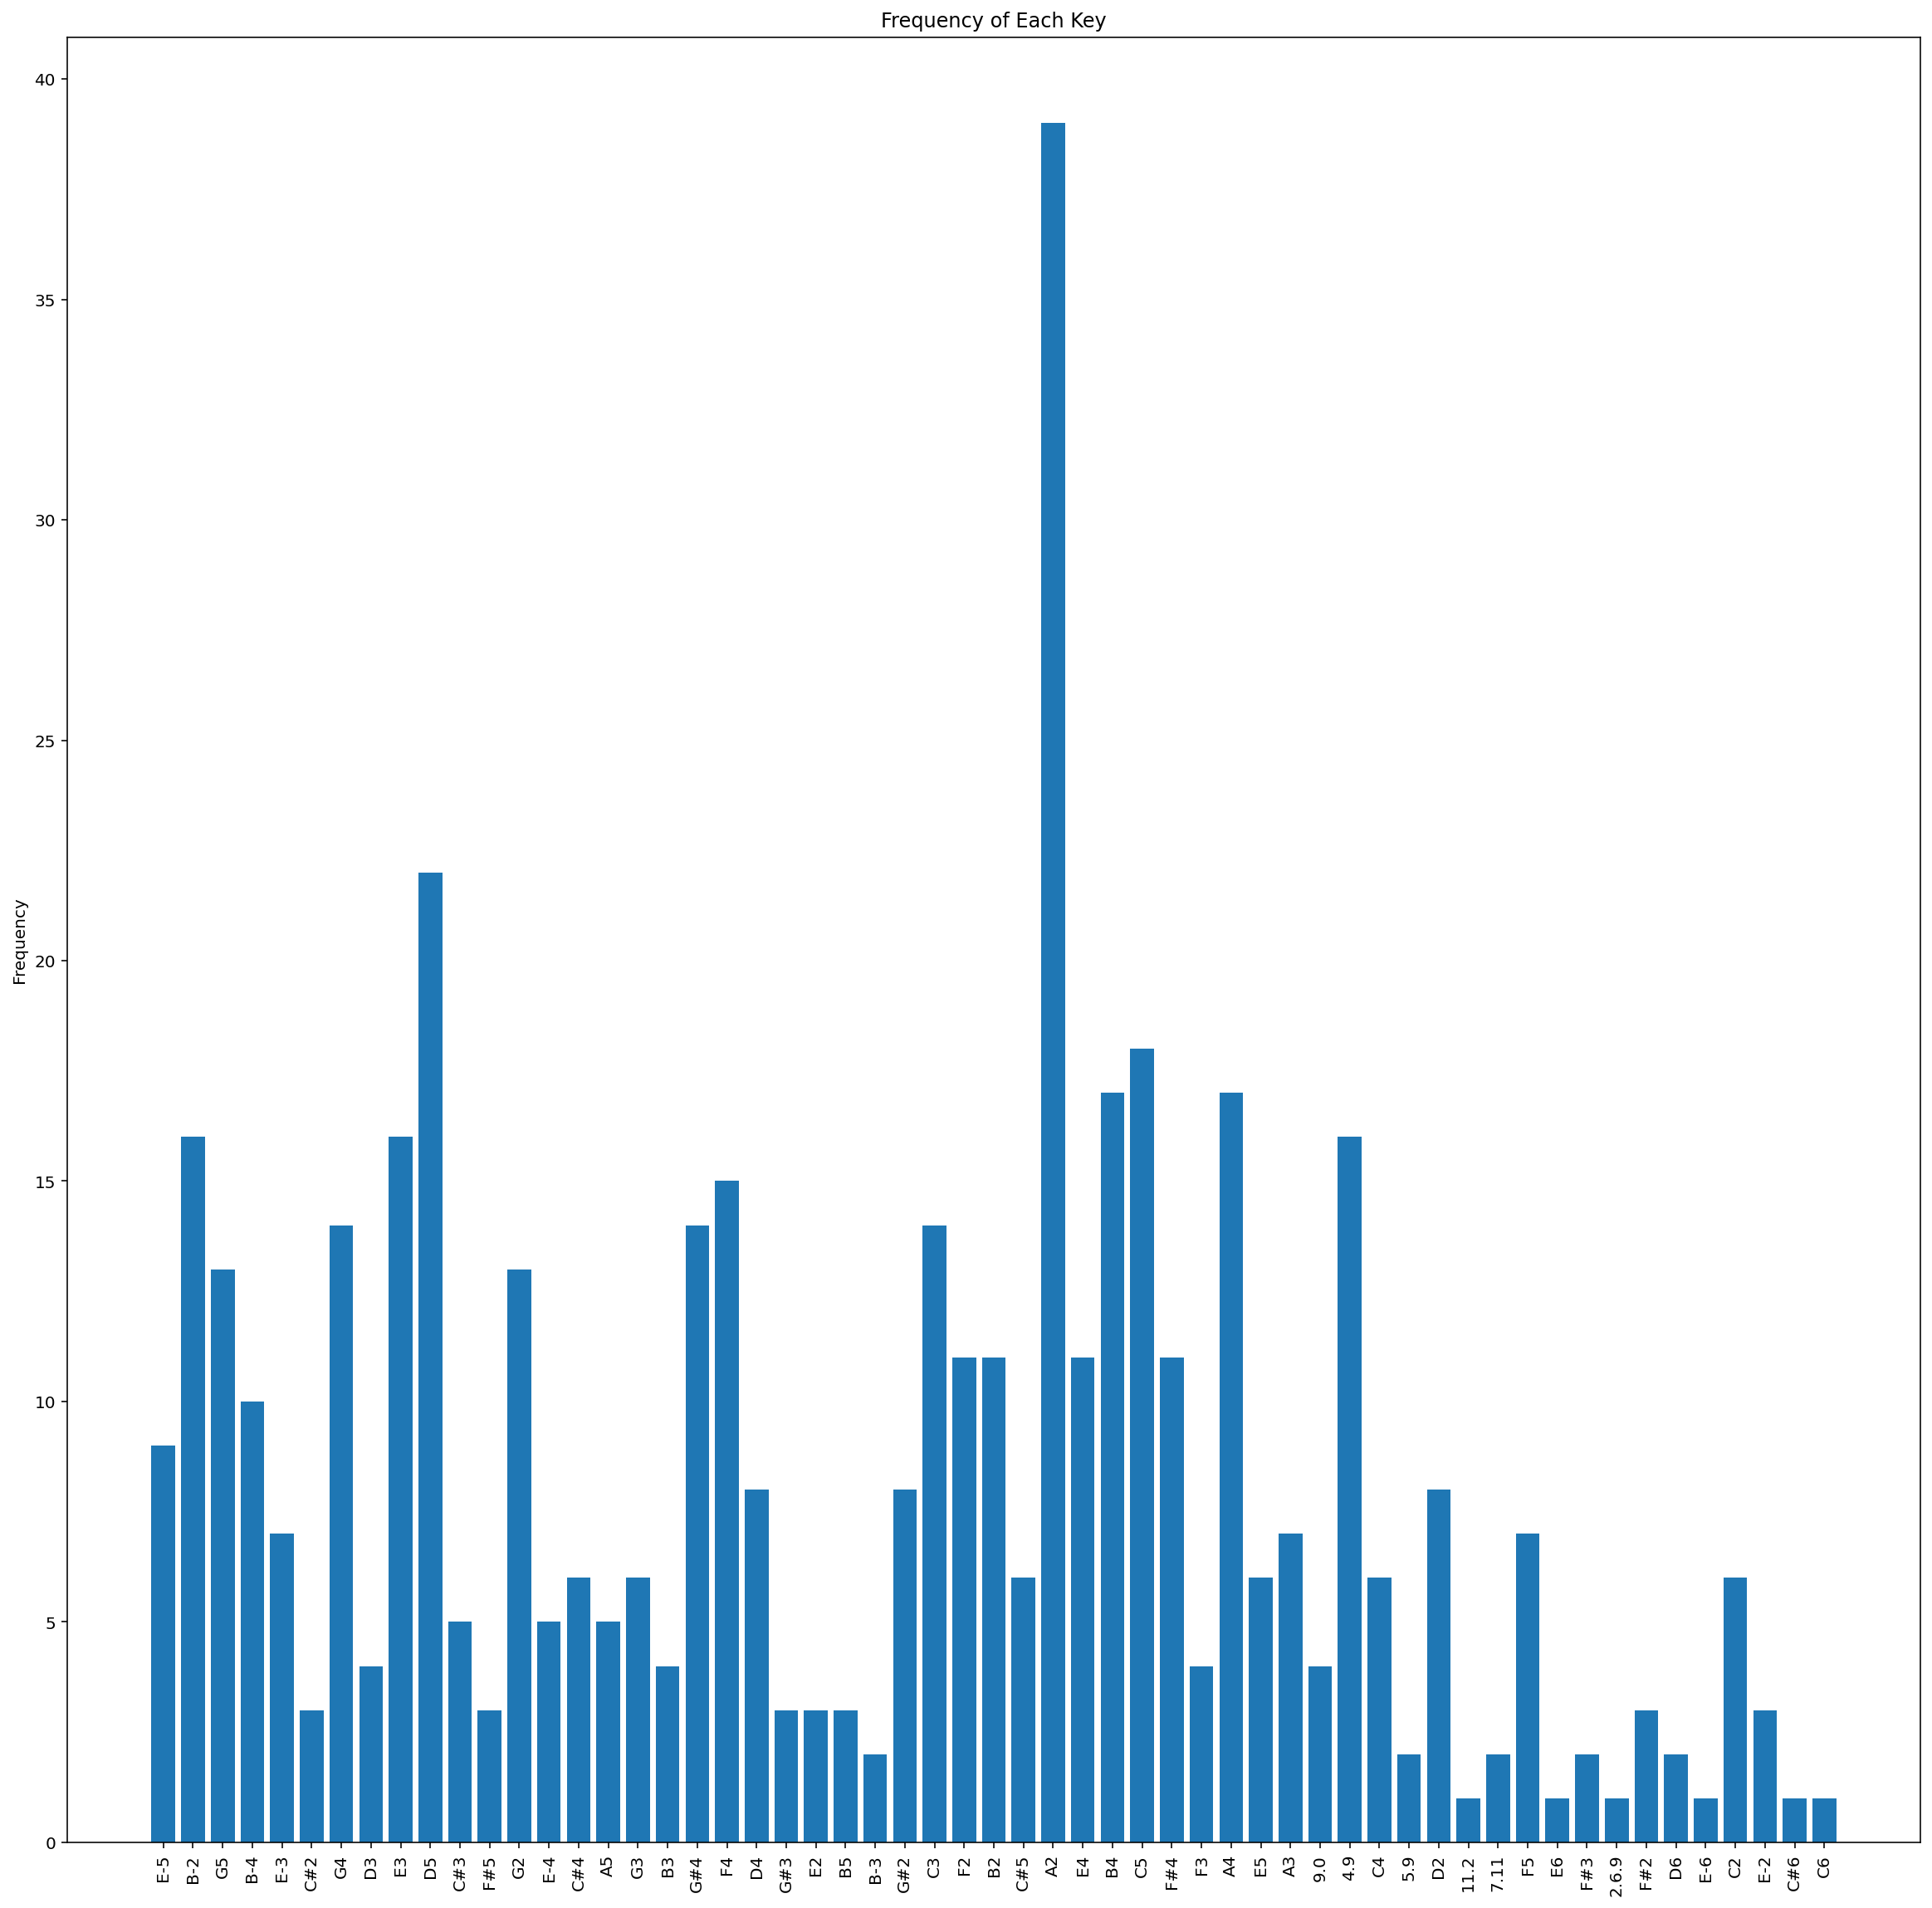

In [ ]:
from collections import Counter

freq = dict(Counter(notee))
n = [i for i in freq.values()]
n_key = [j for j in freq.keys()]
ind = [i for i in range(len(freq))]
ind
fig, ax = plt.subplots(figsize=(20,20))
ax.bar(ind, freq.values())
ax.set_title('Frequency of Each Key')
ax.set_ylabel('Frequency')
plt.xticks(ind, freq.keys(), rotation='vertical')
plt.show()

Libraries are imported
/content/drive/MyDrive/music_project/Classical-Piano-Composer-master
Stage-1
Generating the Notes from the music
Parsing <music21.stream.Score 0x7f2a2bfcfd50>
Parsing <music21.stream.Score 0x7f2a316d2450>
Parsing <music21.stream.Score 0x7f2a32b9fd50>
Parsing <music21.stream.Score 0x7f2a347fa590>
Parsing <music21.stream.Score 0x7f2a30fa4650>
Parsing <music21.stream.Score 0x7f2a24e80cd0>
Parsing <music21.stream.Score 0x7f2a30822510>
Parsing <music21.stream.Score 0x7f2a30822990>
Parsing <music21.stream.Score 0x7f2a34e44990>
Parsing <music21.stream.Score 0x7f2a2b4dba10>
Parsing <music21.stream.Score 0x7f2a2523b2d0>
Parsing <music21.stream.Score 0x7f2a22e1cb50>
Parsing <music21.stream.Score 0x7f2a2ad9e250>
Parsing <music21.stream.Score 0x7f2a33553c90>
Parsing <music21.stream.Score 0x7f2a35d5abd0>
Parsing <music21.stream.Score 0x7f2a29cadf50>
Parsing <music21.stream.Score 0x7f2a36270290>
Parsing <music21.stream.Score 0x7f2a3115f8d0>
Parsing <music21.stream.Score 0x7f2a

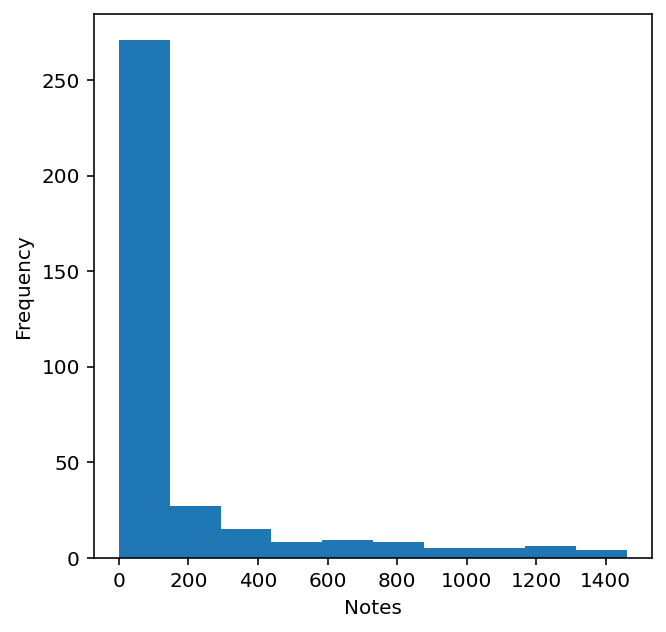

the Notes are generated for the training music
------------------------------------------------------------------------------------
Stage-2
Now we processing the notes to get the input sequence for the LSTM network and corresponding output
Sequence are generated
------------------------------------------------------------------------------------
Stage-3
Creating the network for training the model
The network for training the model is created now and the structure now looks like 
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100, 128)          66560     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 128)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100, 128)          131584    
________________________________

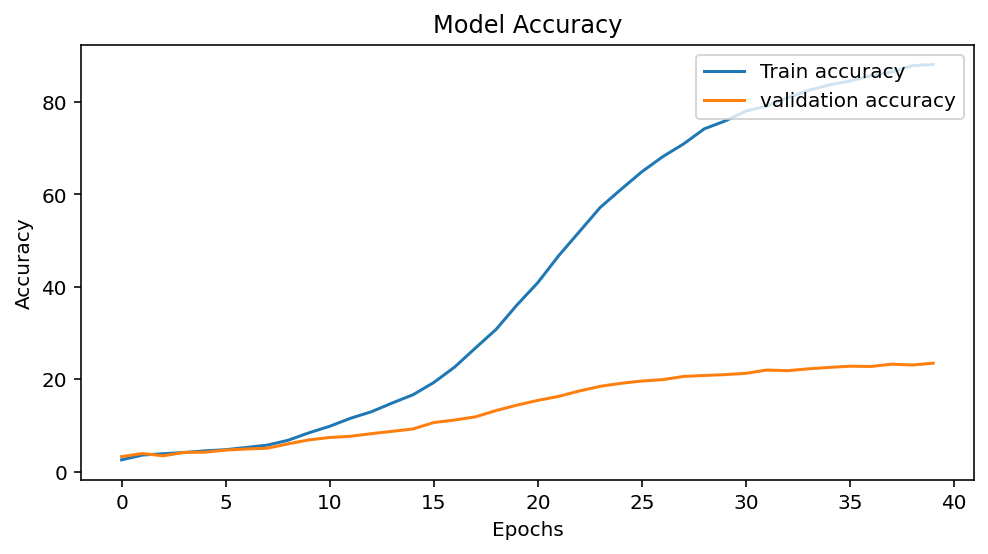

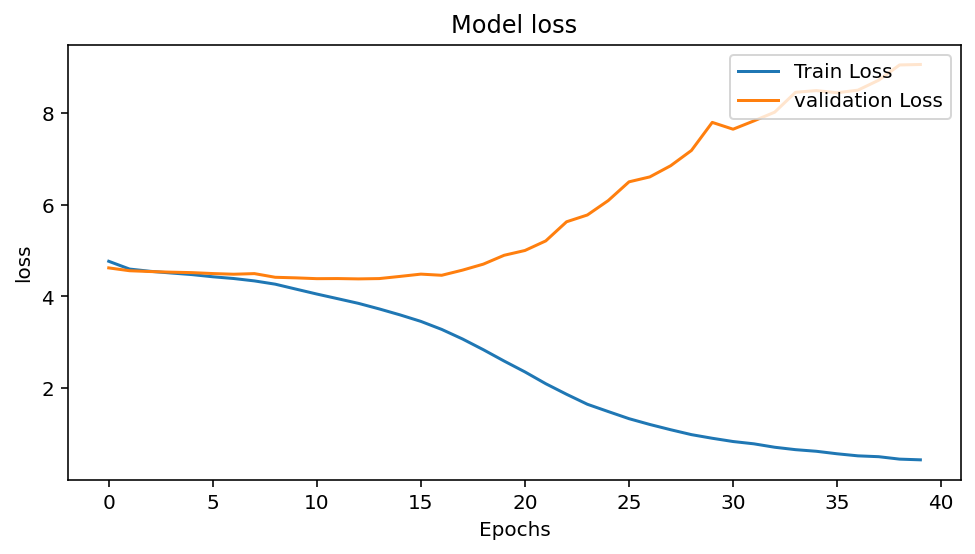

In [ ]:
# midi 50 iterations


import glob
import pickle
import numpy
from music21 import converter, instrument, note, chord
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import BatchNormalization as BatchNorm
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt

import numpy as np
from sklearn.model_selection import train_test_split


import pickle
import numpy
from music21 import instrument, note, stream, chord

print("Libraries are imported")
%cd /content/drive/MyDrive/music_project/Classical-Piano-Composer-master
def final_music_generation():
    print("Stage-1")
    print("Generating the Notes from the music")
    train_notes = notes_extract()

    from collections import Counter
    freq = dict(Counter(train_notes))
    n = [i for i in freq.values()]

    #plots
    plt.figure(figsize=(5,5))
    plt.hist(n)
    plt.xlabel('Notes')
    plt.ylabel('Frequency')
    plt.show()
    print("the Notes are generated for the training music")
    print("------------------------------------------------------------------------------------")
    print("Stage-2")
    print("Now we processing the notes to get the input sequence for the LSTM network and corresponding output")
    input_sequence, output_coded ,train_pitch= input_output_sequences(train_notes)
    train_input_sequence, x_val, train_output_coded, y_val = train_test_split(input_sequence, output_coded,test_size=0.6,random_state=0)
    print("Sequence are generated")
    print("------------------------------------------------------------------------------------")
    print("Stage-3")
    print("Creating the network for training the model")
    # pitches length 
    length_notes=len(train_pitch)

    model=model_create(train_input_sequence, length_notes) 
    print("The network for training the model is created now and the structure now looks like ")
    model.summary()
    #model.tf_model.load_weights('best_model_main.hdf5')
    print('Model Loaded')
    print("------------------------------------------------------------------------------------")
    print("train the network")
    epochs=40
    results=train(model,train_input_sequence, train_output_coded,train_pitch,epochs,x_val,y_val)
    print("The model has been trained and the weights are saved to the files")
    print("Now, run the predict.py file to make a new music")

    return results


def notes_extract():
    """ Get all the notes and chords from the midi files in the ./midi_songs directory """
    """
    Function- notes_extract

    Input - None
    Function- We are getting the notes and the chords that are preprocessed from the music files mainly the midi files.
    output- Notes file that will be saved in a folder and also the informations that are collected from the notes and the chords 

    """
    main = []

    for info in glob.glob("midi_songs_new/*.mid"): # looking at the each files to get the all the list of notes and the chords that are present in the songs
        list_midi = converter.parse(info)

        print("Parsing %s" % list_midi)

        notes_parts = None
        
        # file has instrument parts along with the piano and some flat structure
        try: 
            s2 = instrument.partitionByInstrument(list_midi)
            notes_parts = s2.parts[0].recurse() 
            #print(s2)
            #print(notes_parts)
        except:

            # to extract the flat structures in the music
            notes_parts = list_midi.flat.notes
            #print(notes_parts)

        # after we separte the data from the music stream with the help of the music21, we can extract the notes and the chords from the music files.
        # As, we said, the data can be slplited into 2 types such as notes and the Chords.
        for objects in notes_parts: 
            #print(objects)
            # Instance is to check the instance of the class like whether notes or chords
            if isinstance(objects, note.Note): # to check whether it is a notes 
                main.append(str(objects.pitch))
            elif isinstance(objects, chord.Chord):
               # to check whether it is a chord in the music file and appendind it to the file 
                main.append('.'.join(str(n) for n in objects.normalOrder))


    #To save the notes that we have collected from the previous methods.
    with open('data/midi_songs_new50', 'wb') as path: # we are saving it in the data folder and the in the name of notes
        pickle.dump(main, path)

    return main


def input_output_sequences(notes):
   
    #the sequence length is used in the sequence the network which mainly to predict the next notes with the help of the previous 100 notes that would help to make the prediction of music sequence.
    length_seq = 100
    
    # creating a empty sequency for the both input and the output
    input_sequence = []
    output_coded = []

    # we storing the collection of the  multiple notes and chords in the notes variable like
    # we will have many repeated names of notes and chords that are occuring in the music and we are storing that here (ie) pitches in the music

    pitch = sorted(set(item for item in notes))
    n=len(pitch)

    # creating  a dict which will map or join the pitches and its intgers
    #note_to_int = dict((note, number) for number, note in enumerate(pitch))
    a=[]
    b=[]
    for inte, note in enumerate(pitch):
      a.append(inte)
      b.append(note)
    a_dict = {value: key for key, value in zip(a, b)}
      
    #print(a_dict)
    input_lenght=len(notes)-100

    # create input sequences and the corresponding outputs
    input_sequence=[]
    for i in range(0, input_lenght):
        #print(i)
        # for input sequence
        input = notes[i:i + length_seq]
        input_sequence.append([a_dict[char] for char in input])
        #for char in input:
         # input_sequence.append([a_dict[char]])
        # for output sequence
        out = notes[i + length_seq]
        output_coded.append(a_dict[out])


    # reshape the input for the lstm sequence
    input_sequence = numpy.reshape(input_sequence, (len(input_sequence), length_seq, 1))
    # normalize input

    input_sequence = input_sequence / float(n)
    #one-hot encode the output.

    output_coded = np_utils.to_categorical(output_coded)

    return (input_sequence, output_coded,pitch)



def model_create(network_input, n_vocab):
    """ create the structure of the neural network """
    from keras.layers import Activation, Dense, LSTM, Dropout, Flatten
    model = Sequential()
    model.add(LSTM(128, input_shape=network_input.shape[1:], return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(128, return_sequences=True))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Dropout(0.3))
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

def train(LSTM_model,train_input_sequence, train_output_coded,train_pitch,epo,x_val,y_val):
  # pitches length 
  length_notes=len(train_pitch)

  # make LSTM model 
  #LSTM_model=model(train_input_sequence, train_output_coded, length_notes) 
  #LSTM_model.summary()

  files = ModelCheckpoint(
          "weights_midi_songs_new50.hdf5",
          monitor='loss',
          mode='min',
          save_best_only=True,
          verbose=0)

  # train the model
  results=LSTM_model.fit(train_input_sequence, train_output_coded, batch_size=128,epochs=epo,validation_data=(x_val,y_val),callbacks=[files])

  return results


results=final_music_generation()

acc=results.history['accuracy']
acc = [element * 100 for element in acc]
val_acc=results.history['val_accuracy']
val_acc = [element * 100 for element in val_acc]

plt.figure(figsize=(8,4))
plt.plot(acc, label='Train accuracy')
plt.plot(val_acc, label='validation accuracy')

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.show();
#plt.savefig('plot.png')   # or you can pass a Figure object to pdf.savefig
#plt.close()
plt.figure(figsize=(8,4))
plt.plot(results.history['loss'], label='Train Loss')
plt.plot(results.history['val_loss'], label='validation Loss')
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.show();
